# LeNet 5

Author: Franco Hernández Victor Alfonso

<a href="https://colab.research.google.com/github/VictorFranco/fastapi-lenet-mnist/blob/main/LeNet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import nn

transform_train = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0],[1])
])

trainset = datasets.MNIST(
    "MNIST_data",
    train = True,
    transform = transform_train,
    download = True
)

testset = datasets.MNIST(
    "MNIST_data",
    transform = transform_train,
    download = True
)

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0], std=[1])
           )
torch.Size([1, 32, 32])


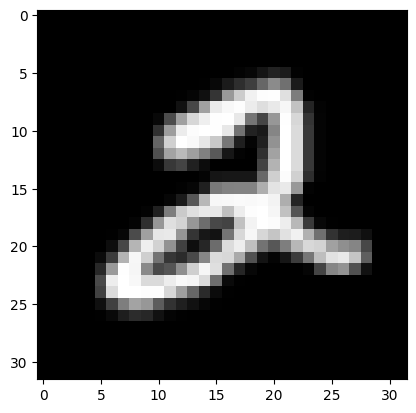

In [ ]:
print(trainset)
# print(trainset[5])
print(trainset[5][0].shape)
plt.imshow(trainset[5][0].permute(1,2,0),cmap='gray')

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64)
# next(iter(trainloader))

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn = nn.Sequential(
        nn.Conv2d(1,6,5),
        nn.Tanh(),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(6,16,5),
        nn.Tanh(),
        nn.MaxPool2d(2, stride=2)
    )
    self.fc = nn.Sequential(
        nn.Linear(16*5*5,120),
        nn.Tanh(),
        nn.Linear(120,84),
        nn.Tanh(),
        nn.Linear(84,10),
        nn.Softmax(dim=1)
    )
  def forward(self, x):
    x = self.cnn(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(40)
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [ ]:
def validation(model):
  model.eval()
  correct_predictions = 0
  for images, labels in testloader:
    outputs = model(images.to(device))
    predictions = torch.argmax(outputs, dim=1)
    bool_predictions = torch.eq(labels.to(device),predictions)
    correct_predictions += bool_predictions.sum()
  return correct_predictions / 60000 * 100
# print(validation(model))

In [ ]:
print_every = 100
for epoch in range(3):
  steps = 0
  running_loss = 0
  for images, labels in trainloader:
    model.train()
    outputs = model(images.to(device))
    optimizer.zero_grad()
    loss = criterion(outputs, labels.to(device))
    loss.backward()
    optimizer.step()
    steps += 1
    running_loss += loss.item()
    if steps % print_every == 0:
      model.eval()
      with torch.inference_mode():
        accuracy = validation(model)
        print("epoch:{}/{} loss:{:.3f} acc:{:.3f}%".format(epoch+1,3,running_loss/print_every,accuracy))
        running_loss = 0

epoch:1/3 loss:2.302 acc:9.822%
epoch:1/3 loss:2.302 acc:11.843%
epoch:1/3 loss:2.301 acc:13.322%
epoch:1/3 loss:2.300 acc:16.875%
epoch:1/3 loss:2.298 acc:27.368%
epoch:1/3 loss:2.296 acc:33.048%
epoch:1/3 loss:2.289 acc:27.458%
epoch:1/3 loss:2.269 acc:22.547%
epoch:1/3 loss:2.208 acc:24.685%
epoch:2/3 loss:2.148 acc:34.620%
epoch:2/3 loss:2.101 acc:41.583%
epoch:2/3 loss:2.047 acc:47.618%
epoch:2/3 loss:1.979 acc:57.512%
epoch:2/3 loss:1.916 acc:66.170%
epoch:2/3 loss:1.843 acc:71.573%
epoch:2/3 loss:1.788 acc:73.997%
epoch:2/3 loss:1.749 acc:76.788%
epoch:2/3 loss:1.712 acc:79.882%
epoch:3/3 loss:1.674 acc:85.945%
epoch:3/3 loss:1.651 acc:88.988%
epoch:3/3 loss:1.628 acc:89.823%
epoch:3/3 loss:1.602 acc:90.515%
epoch:3/3 loss:1.600 acc:90.957%
epoch:3/3 loss:1.584 acc:91.558%
epoch:3/3 loss:1.576 acc:92.157%
epoch:3/3 loss:1.573 acc:92.512%
epoch:3/3 loss:1.557 acc:92.805%


In [ ]:
torch.save(model, "cnn.pth")

In [ ]:
!pip install onnx

In [ ]:
import torch
model = torch.load("cnn.pth")
example = torch.zeros(1,1,32,32).to(device)
in_names = ["in"]
out_names = ["out"]
torch.onnx.export(model, example, "cnn.onnx", input_names=in_names, output_names=out_names, verbose=True)